# **Neural Networks Models**

Maintainer: Zhaohu(Jonathan) Fan. Contact him at (psujohnny@gmail.com)

Note: This lab note is still WIP, let us know if you encounter bugs or issues.


## Table of Contents
1. [Neural Networks Models](#neural-networks-models)
   1. [Regression](#11-regression)
   2. [Classification on Bankruptcy Dataset](#12-classification-on-bankruptcy-dataset)


#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/1a7WoNbwrHs6isl4ywtEe28Yc06Q2JY-H?usp=sharing)*

#### *Useful information about [Neural Networks Models in R](https://yanyudm.github.io/Data-Mining-R/lecture/9.A_NeuralNet.html)*




# 1 Neural Networks Models
Neural Networks are flexible nonlinear models that can be evaluated using:
- **In-sample performance** (training set)
- **Out-of-sample performance** (test set)

In Python, we use:
- `MLPRegressor` for **regression**
- `MLPClassifier` for **classification**

> **Important:** Scaling/standardization is strongly recommended for neural networks.


This notebook illustrates **Neural Networks** for:
- **Regression** (in-sample + out-of-sample performance)
- **Classification** (Bankruptcy dataset)


In [12]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf    # use "pip install tensorflow" if not previously installed
from keras.models import Sequential
from keras.layers import Dense

In [13]:
import warnings

# Hide the specific jupyter_client utcnow() deprecation warning in Colab
warnings.filterwarnings(
    "ignore",
    message=r".*datetime\.datetime\.utcnow\(\) is deprecated.*",
    category=DeprecationWarning,
    module=r"jupyter_client\.session",
)

# 1.1 Regression (Neural Networks)

For **regression**, the R function `neuralnet(..., linear.output = TRUE)` fits a network with a **linear output layer** (continuous response).  
In Python, the closest equivalent is `sklearn.neural_network.MLPRegressor`.

In practice, **normalization / standardization** of predictors (and sometimes the response) is strongly recommended for neural networks. Otherwise, optimization may fail to converge (similar to R’s: *“Algorithm did not converge … within stepmax”*).

Below is the Python/Colab version of the workflow:
1) Load Boston data from CMU  
2) Apply **min-max scaling to [0, 1]** (like your R code)  
3) Train/test split (90% train)  
4) Fit an NN regression model with hidden layers (5, 3)  
5) Predict on test set  
6) **Recover predictions back to original MEDV scale**  
7) Compute **MSPE**


In [14]:
# ------------------------------------------------------------
# 1) Load Boston dataset (same source you used earlier)
# ------------------------------------------------------------
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)

data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

boston = pd.DataFrame(
    data,
    columns=["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS",
             "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
)
boston["MEDV"] = target

boston.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [15]:
# ------------------------------------------------------------
# 2) Min-max scaling to [0, 1] (matches your R scaling approach)
#    scaled = (x - min) / (max - min)
# ------------------------------------------------------------
X = boston.drop(columns=["MEDV"])
y = boston["MEDV"].values.reshape(-1, 1)

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y).ravel()  # flatten to shape (n,)

# 90% train split (like your R sample of 0.9*n)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.10, random_state=42
)

X_train.shape, X_test.shape


((455, 13), (51, 13))

In [19]:
# ------------------------------------------------------------
# 3) Fit Neural Network regression model
#    R: hidden=c(5,3), linear.output=TRUE
#    Python: MLPRegressor with hidden_layer_sizes=(5,3)
# ------------------------------------------------------------
nn = MLPRegressor(
    hidden_layer_sizes=(5, 3),
    activation="relu",
    solver="adam",
    alpha=1e-4,          # L2 regularization (similar spirit to weight decay)
    learning_rate_init=1e-3,
    max_iter=5000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=30
)

nn.fit(X_train, y_train)

print(f"Training iterations used: {nn.n_iter_}")
print(f"Final training loss: {nn.loss_:.4f}")


Training iterations used: 257
Final training loss: 0.0142


In [20]:
# ------------------------------------------------------------
# 4) Predict on test set (scaled), then recover original MEDV scale
#    R:
#      pr_nn_org <- pr*(max-min) + min
#    Python:
#      inverse_transform does the same recovery
# ------------------------------------------------------------
y_pred_scaled = nn.predict(X_test).reshape(-1, 1)

# back to original MEDV scale
y_pred = y_scaler.inverse_transform(y_pred_scaled).ravel()
y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# ------------------------------------------------------------
# 5) MSPE (mean squared prediction error) on test set
# ------------------------------------------------------------
mspe = mean_squared_error(y_true, y_pred)
print(f"Test MSPE: {mspe:.4f}")


Test MSPE: 54.4174


In [22]:
# Train MSPE
y_train_pred_scaled = nn.predict(X_train).reshape(-1, 1)
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled).ravel()
y_train_true = y_scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()

mspe_train = mean_squared_error(y_train_true, y_train_pred)
mspe_test  = mean_squared_error(y_true, y_pred)

print(f"Train MSPE: {mspe_train:.4f}")
print(f"Test  MSPE: {mspe_test:.4f}")


Train MSPE: 58.6781
Test  MSPE: 54.4174


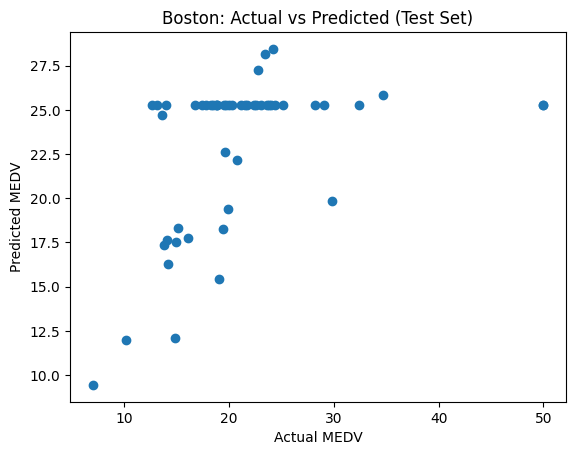

In [21]:
# Optional: quick sanity check plot (Actual vs Predicted)
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_true, y_pred)
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Boston: Actual vs Predicted (Test Set)")
plt.show()


In [18]:
# Optional: show a few predictions
pd.DataFrame({"Actual_MEDV": y_true[:10], "Pred_MEDV": y_pred[:10]})


,Actual_MEDV,Pred_MEDV
0,23.6,25.250968
1,32.4,25.250968
2,13.6,24.707772
3,22.8,27.275886
4,16.1,17.777116
5,20.0,25.250968
6,17.8,25.250968
7,14.0,25.250968
8,19.6,22.604956
9,16.8,25.250968


**Notes (matching the R narrative):**
- If you skip scaling, `MLPRegressor` may converge slowly or perform poorly (and sometimes raises a convergence warning).
- Using min-max scaling to **[0, 1]** reproduces the exact idea of your R code.
- MSPE here is computed on the **original MEDV scale**, just like your R “recover then MSPE” steps.


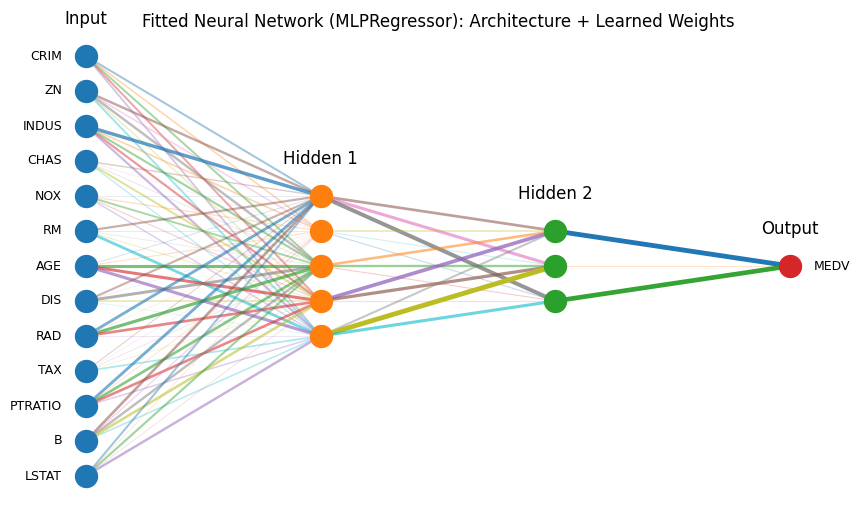

In [23]:
# ------------------------------------------------------------
# Plot the fitted neural network model (architecture + weights)
# Notes:
# - sklearn doesn't provide a built-in "plot(nn)" like R neuralnet.
# - This visual shows the network structure and learned connections
#   (line thickness/opacity reflects |weight| magnitude).
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

def plot_mlp_network(mlp, feature_names=None, max_features=13):
    """
    Visualize an sklearn MLPRegressor/MLPClassifier as a network diagram.
    Edge thickness/alpha reflects absolute weight magnitude.

    max_features: if there are many input features, plot only the first max_features for readability.
    """
    if not hasattr(mlp, "coefs_"):
        raise ValueError("Model must be fitted before plotting. Fit the MLP first.")

    coefs = mlp.coefs_  # list of weight matrices: (n_in x n_h1), (n_h1 x n_h2), ..., (n_last_hidden x n_out)

    layer_sizes = [coefs[0].shape[0]] + [w.shape[1] for w in coefs]  # includes input + hidden(s) + output
    n_layers = len(layer_sizes)

    # If too many input features, truncate for plot readability
    if layer_sizes[0] > max_features:
        keep = max_features
        coefs = [coefs[0][:keep, :]] + coefs[1:]
        layer_sizes[0] = keep
        if feature_names is not None:
            feature_names = list(feature_names)[:keep]
        else:
            feature_names = [f"x{i+1}" for i in range(keep)]
    else:
        if feature_names is None:
            feature_names = [f"x{i+1}" for i in range(layer_sizes[0])]

    # Compute node positions
    x_gap = 1.5
    y_gap = 1.0
    positions = []

    for li, size in enumerate(layer_sizes):
        x = li * x_gap
        # center layer vertically
        y0 = (size - 1) * y_gap / 2.0
        layer_pos = [(x, y0 - i * y_gap) for i in range(size)]
        positions.append(layer_pos)

    # Normalize edge weights for line width/alpha
    all_w = np.concatenate([np.abs(w).ravel() for w in coefs])
    w_max = all_w.max() if all_w.size else 1.0

    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_axis_off()

    # Draw edges
    for li, w in enumerate(coefs):
        for i in range(w.shape[0]):
            for j in range(w.shape[1]):
                x1, y1 = positions[li][i]
                x2, y2 = positions[li + 1][j]

                strength = abs(w[i, j]) / w_max  # in [0,1]
                lw = 0.5 + 3.0 * strength
                alpha = 0.15 + 0.85 * strength

                ax.plot([x1, x2], [y1, y2], linewidth=lw, alpha=alpha)

    # Draw nodes
    for li, layer_pos in enumerate(positions):
        xs = [p[0] for p in layer_pos]
        ys = [p[1] for p in layer_pos]
        ax.scatter(xs, ys, s=250, zorder=3)

    # Label layers
    layer_labels = ["Input"] + [f"Hidden {k}" for k in range(1, n_layers - 1)] + ["Output"]
    for li, label in enumerate(layer_labels):
        x = li * x_gap
        ax.text(x, max([p[1] for p in positions[li]]) + 0.8, label, ha="center", va="bottom", fontsize=12)

    # Label input features (optional)
    for i, name in enumerate(feature_names):
        x, y = positions[0][i]
        ax.text(x - 0.15, y, name, ha="right", va="center", fontsize=9)

    # Label output node(s)
    out_size = layer_sizes[-1]
    for j in range(out_size):
        x, y = positions[-1][j]
        ax.text(x + 0.15, y, "MEDV" if out_size == 1 else f"y{j+1}", ha="left", va="center", fontsize=9)

    plt.title("Fitted Neural Network (MLPRegressor): Architecture + Learned Weights")
    plt.show()


# ---- Call the plotter ----
# If you want Boston feature names on the input layer:
boston_feature_names = X.columns.tolist()  # X was boston.drop(columns=["MEDV"])
plot_mlp_network(nn, feature_names=boston_feature_names, max_features=13)


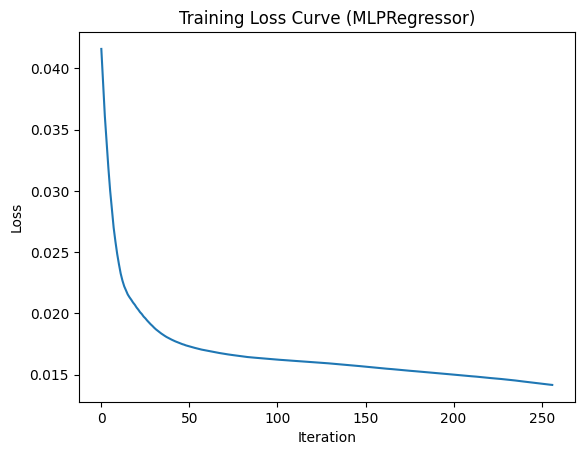

In [24]:
# Optional: also plot the training loss curve (closest quick diagnostic to R’s plot(nn))
plt.figure()
plt.plot(nn.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Curve (MLPRegressor)")
plt.show()


## 1.2 Classification on Bankruptcy dataset

For **classification** problems, the neural network uses a **categorical (nonlinear) output layer**—in R, this corresponds to `neuralnet(..., linear.output = FALSE)`.  
In Python (Google Colab), the equivalent approach is to use a classifier such as `sklearn.neural_network.MLPClassifier`.

As with regression, it is a best practice to **scale or standardize the predictor variables** before training a neural network. Without scaling, training can be unstable, converge slowly, or yield poor performance.



In [25]:
# ============================================================
# Bankrupt Neural Network (Python / Google Colab)
# - Replicates the R workflow using sklearn + pandas
# - Min-max scales columns except the first 3 (like R code)
# - 70/30 train-test split
# - MLPClassifier with hidden layer size=3
# - In-sample / out-of-sample confusion matrix at pcut = 1/36
# - ROC curve + AUC
# - AIC/BIC + mean residual deviance (computed from log-likelihood)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, roc_auc_score, log_loss
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [26]:
# -----------------------------
# 1) Load data
# -----------------------------
url = "https://yanyudm.github.io/Data-Mining-R/lecture/data/bankruptcy.csv"
Bank_data = pd.read_csv(url)

print("Shape:", Bank_data.shape)
Bank_data.head()


Shape: (5436, 13)


,FYEAR,DLRSN,CUSIP,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10
0,1999,0,00036020,0.307139,0.887006,1.647681,-0.199158,1.092964,-0.313289,-0.196793,1.206763,0.282471,0.158896
1,1999,0,00036110,0.760736,0.592493,0.453003,-0.369890,0.186154,0.039619,0.327497,0.428418,1.106965,0.793443
2,1999,0,00037520,-0.513596,0.337615,0.299015,-0.029080,-0.432605,0.829993,-0.707786,0.476153,2.179175,2.484584
3,1994,1,00078110,-0.466129,0.370747,0.496067,-0.373429,-0.267424,0.977799,-0.610975,0.456810,0.151951,0.047789
4,1999,0,00079X10,2.023422,0.214876,0.182595,6.695360,-1.148338,-1.505889,2.876477,0.287375,-0.986442,0.791077


In [27]:
# -----------------------------
# 2) Min-max scale columns except first 3 (matches R: Bank_data[,-c(1:3)])
# -----------------------------
Bank_data_scaled = Bank_data.copy()

cols_to_scale = Bank_data_scaled.columns[3:]  # all columns except first 3
scaler = MinMaxScaler(feature_range=(0, 1))
Bank_data_scaled[cols_to_scale] = scaler.fit_transform(Bank_data_scaled[cols_to_scale])

Bank_data_scaled.head()


,FYEAR,DLRSN,CUSIP,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10
0,1999,0,00036020,0.732090,0.839453,0.882382,0.032006,0.454959,0.180252,0.252224,0.811392,0.616264,0.505023
1,1999,0,00036110,0.802896,0.760436,0.598388,0.008035,0.287034,0.233591,0.379792,0.626457,0.783073,0.640074
2,1999,0,00037520,0.603974,0.692052,0.561782,0.055885,0.172452,0.353049,0.127891,0.637799,1.000000,1.000000
3,1994,1,00078110,0.611383,0.700941,0.608625,0.007538,0.203040,0.375389,0.151447,0.633203,0.589858,0.481376
4,1999,0,00079X10,1.000000,0.659121,0.534107,1.000000,0.039911,0.000000,1.000000,0.592945,0.359541,0.639570


In [28]:
# -----------------------------
# 3) Train/test split (70% train), like R sample()
# -----------------------------
Bank_train, Bank_test = train_test_split(
    Bank_data_scaled,
    test_size=0.30,
    random_state=42,
    shuffle=True
)

print("Train shape:", Bank_train.shape)
print("Test  shape:", Bank_test.shape)


Train shape: (3805, 13)
Test  shape: (1631, 13)


In [29]:
# -----------------------------
# 4) Specify response + predictors (matches R formula)
#    f <- DLRSN ~ R1 + ... + R10
# -----------------------------
y_col = "DLRSN"
x_cols = [f"R{i}" for i in range(1, 11)]

missing = [c for c in [y_col] + x_cols if c not in Bank_train.columns]
if missing:
    raise ValueError(f"Missing columns in data: {missing}\nAvailable columns: {list(Bank_train.columns)}")

X_train = Bank_train[x_cols].values
y_train = Bank_train[y_col].astype(int).values

X_test  = Bank_test[x_cols].values
y_test  = Bank_test[y_col].astype(int).values

print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))


Train class counts: [3260  545]
Test  class counts: [1400  231]


In [30]:
# -----------------------------
# 5) Fit NN classifier (closest to R neuralnet classification)
#    R: hidden=c(3), linear.output=F, likelihood=T
# -----------------------------
clf = MLPClassifier(
    hidden_layer_sizes=(3,),   # hidden=c(3)
    activation="logistic",     # logistic output-like behavior
    solver="adam",
    alpha=1e-4,
    max_iter=5000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=30
)

clf.fit(X_train, y_train)

print("Iterations used:", clf.n_iter_)
print("Final loss:", f"{clf.loss_:.4f}")


Iterations used: 44
Final loss: 0.4866


In [31]:
# -----------------------------
# 6) Helper: AIC/BIC + mean residual deviance from log-likelihood
#    (sklearn doesn't output AIC/BIC; we compute from predicted probabilities)
# -----------------------------
def n_params_mlp(model) -> int:
    """Count number of parameters (weights + biases) in a fitted sklearn MLP."""
    return int(sum(w.size for w in model.coefs_) + sum(b.size for b in model.intercepts_))

def aic_bic_deviance(y_true, p1, k: int):
    """
    y_true: {0,1}
    p1: predicted probability for class 1
    k: number of parameters
    Returns: (aic, bic, deviance, mean_resid_deviance, loglik)
    """
    p1 = np.clip(p1, 1e-15, 1 - 1e-15)
    ll = np.sum(y_true * np.log(p1) + (1 - y_true) * np.log(1 - p1))  # log-likelihood
    dev = -2 * ll
    n = len(y_true)
    aic = 2 * k - 2 * ll
    bic = np.log(n) * k - 2 * ll
    mrd = dev / n
    return aic, bic, dev, mrd, ll


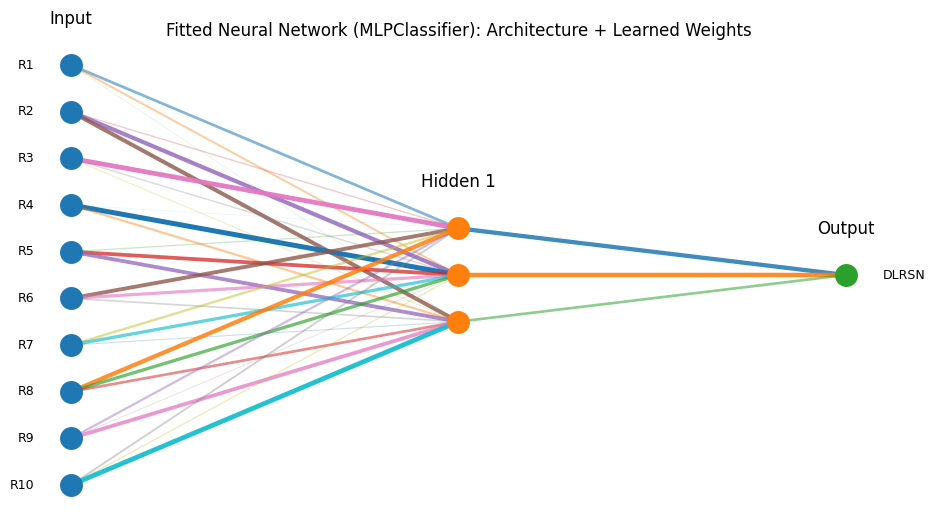

In [38]:
# ============================================================
# Plot the fitted neural network model (MLPClassifier)
# - sklearn doesn't have an exact equivalent to R's plot(neuralnet)
# - This plot shows the network architecture and learned weights
#   (edge thickness/opacity ∝ |weight|)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

def plot_mlp_network(mlp, feature_names=None, output_names=None, max_features=20):
    """
    Visualize an sklearn MLPClassifier/MLPRegressor as a network diagram.
    Edge thickness/alpha reflects absolute weight magnitude.

    max_features: if many input features, plot only the first max_features for readability.
    """
    if not hasattr(mlp, "coefs_"):
        raise ValueError("Model must be fitted before plotting. Fit the MLP first.")

    coefs = mlp.coefs_  # [(n_in x n_h1), (n_h1 x n_h2), ..., (n_last_hidden x n_out)]
    layer_sizes = [coefs[0].shape[0]] + [w.shape[1] for w in coefs]
    n_layers = len(layer_sizes)

    # If too many input features, truncate first-layer weights
    if layer_sizes[0] > max_features:
        keep = max_features
        coefs = [coefs[0][:keep, :]] + coefs[1:]
        layer_sizes[0] = keep
        if feature_names is None:
            feature_names = [f"x{i+1}" for i in range(keep)]
        else:
            feature_names = list(feature_names)[:keep]
    else:
        if feature_names is None:
            feature_names = [f"x{i+1}" for i in range(layer_sizes[0])]

    # Output node labels
    if output_names is None:
        if layer_sizes[-1] == 1:
            output_names = ["y"]
        else:
            output_names = [f"out{j+1}" for j in range(layer_sizes[-1])]

    # Node positions
    x_gap = 1.6
    y_gap = 1.0
    positions = []
    for li, size in enumerate(layer_sizes):
        x = li * x_gap
        y0 = (size - 1) * y_gap / 2.0
        positions.append([(x, y0 - i * y_gap) for i in range(size)])

    # Normalize weights for styling
    all_w = np.concatenate([np.abs(w).ravel() for w in coefs])
    w_max = all_w.max() if all_w.size else 1.0

    plt.figure(figsize=(11, 6))
    ax = plt.gca()
    ax.set_axis_off()

    # Draw edges
    for li, w in enumerate(coefs):
        for i in range(w.shape[0]):
            for j in range(w.shape[1]):
                x1, y1 = positions[li][i]
                x2, y2 = positions[li + 1][j]
                strength = abs(w[i, j]) / w_max  # [0,1]
                lw = 0.4 + 3.2 * strength
                alpha = 0.10 + 0.90 * strength
                ax.plot([x1, x2], [y1, y2], linewidth=lw, alpha=alpha)

    # Draw nodes
    for li, layer_pos in enumerate(positions):
        xs = [p[0] for p in layer_pos]
        ys = [p[1] for p in layer_pos]
        ax.scatter(xs, ys, s=240, zorder=3)

    # Layer labels
    layer_labels = ["Input"] + [f"Hidden {k}" for k in range(1, n_layers - 1)] + ["Output"]
    for li, label in enumerate(layer_labels):
        x = li * x_gap
        top_y = max(p[1] for p in positions[li])
        ax.text(x, top_y + 0.8, label, ha="center", va="bottom", fontsize=12)

    # Input feature labels
    for i, name in enumerate(feature_names):
        x, y = positions[0][i]
        ax.text(x - 0.15, y, name, ha="right", va="center", fontsize=9)

    # Output labels
    for j, name in enumerate(output_names):
        x, y = positions[-1][j]
        ax.text(x + 0.15, y, name, ha="left", va="center", fontsize=9)

    plt.title("Fitted Neural Network (MLPClassifier): Architecture + Learned Weights")
    plt.show()


# ---- Call it for your bankruptcy model ----
# Inputs are R1..R10, output is DLRSN
plot_mlp_network(
    clf,
    feature_names=[f"R{i}" for i in range(1, 11)],
    output_names=["DLRSN"],
    max_features=20
)


In [32]:
# -----------------------------
# 7) In-sample performance (confusion matrix) using pcut = 1/36
# -----------------------------
pcut_nn = 1 / 36

prob_nn_in = clf.predict_proba(X_train)[:, 1]
pred_nn_in = (prob_nn_in >= pcut_nn).astype(int)

cm_in = confusion_matrix(y_train, pred_nn_in)
cm_in_df = pd.DataFrame(cm_in, index=["Observed 0", "Observed 1"], columns=["Pred 0", "Pred 1"])
cm_in_df


,Pred 0,Pred 1
Observed 0,0,3260
Observed 1,0,545


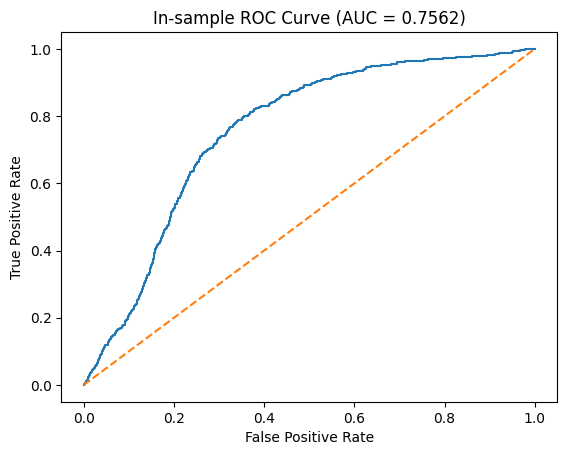

In-sample AUC: 0.7562


In [33]:
# In-sample ROC + AUC
auc_in = roc_auc_score(y_train, prob_nn_in)
fpr_in, tpr_in, _ = roc_curve(y_train, prob_nn_in)

plt.figure()
plt.plot(fpr_in, tpr_in)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"In-sample ROC Curve (AUC = {auc_in:.4f})")
plt.show()

print(f"In-sample AUC: {auc_in:.4f}")


In [34]:
# In-sample AIC/BIC + mean residual deviance (computed)
k = n_params_mlp(clf)
aic_in, bic_in, dev_in, mrd_in, ll_in = aic_bic_deviance(y_train, prob_nn_in, k)

print(f"Number of parameters (k): {k}")
print(f"AIC: {aic_in:.4f}")
print(f"BIC: {bic_in:.4f}")
print(f"Deviance: {dev_in:.4f}")
print(f"Mean residual deviance: {mrd_in:.4f}")


Number of parameters (k): 37
AIC: 4843.5171
BIC: 5074.5478
Deviance: 4769.5171
Mean residual deviance: 1.2535


In [35]:
# -----------------------------
# 8) Out-of-sample performance (confusion matrix) using same pcut
# -----------------------------
prob_nn_out = clf.predict_proba(X_test)[:, 1]
pred_nn_out = (prob_nn_out >= pcut_nn).astype(int)

cm_out = confusion_matrix(y_test, pred_nn_out)
cm_out_df = pd.DataFrame(cm_out, index=["Observed 0", "Observed 1"], columns=["Pred 0", "Pred 1"])
cm_out_df


,Pred 0,Pred 1
Observed 0,0,1400
Observed 1,0,231


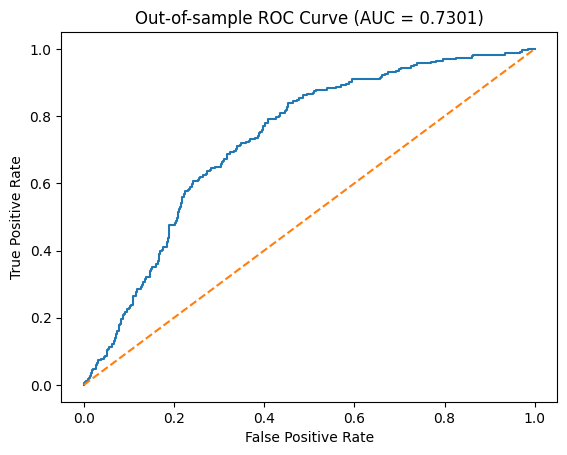

Out-of-sample AUC: 0.7301


In [36]:
# Out-of-sample ROC + AUC
auc_out = roc_auc_score(y_test, prob_nn_out)
fpr_out, tpr_out, _ = roc_curve(y_test, prob_nn_out)

plt.figure()
plt.plot(fpr_out, tpr_out)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Out-of-sample ROC Curve (AUC = {auc_out:.4f})")
plt.show()

print(f"Out-of-sample AUC: {auc_out:.4f}")


In [37]:
# Optional: Out-of-sample AIC/BIC + mean residual deviance (same k)
aic_out, bic_out, dev_out, mrd_out, ll_out = aic_bic_deviance(y_test, prob_nn_out, k)

print(f"(Test) AIC: {aic_out:.4f}")
print(f"(Test) BIC: {bic_out:.4f}")
print(f"(Test) Deviance: {dev_out:.4f}")
print(f"(Test) Mean residual deviance: {mrd_out:.4f}")


(Test) AIC: 2117.9920
(Test) BIC: 2317.6791
(Test) Deviance: 2043.9920
(Test) Mean residual deviance: 1.2532


In [ ]:
%%shell
jupyter nbconvert --to html ///content/9_A_Neural_Networks_Models.ipynb